In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import h5py
import explain
import custom_fit
import modelzoo
import os,json
import util
import time
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import seaborn as sns
import explain
from tqdm import tqdm
from tfr_evaluate import collect_run_dirs
import glob
import test_to_bw_fast, tfr_evaluate
import metrics

# Whole test set performance VS peak centered dataset robustness

In [2]:
# testset_path = '/mnt/1a18a49e-9a31-4dbf-accd-3fb8abbfab2d/shush/4grid_atac/complete/peak_centered/i_3072_w_1/'
# targets_path = os.path.join(testset_path, 'targets.txt')
# targets = pd.read_csv(targets_path, delimiter='\t')['identifier'].values


In [5]:
performance_bpnet = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/augmentation_48.csv')
performance_basenji = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/augmentation_basenji.csv')

performance_whole = pd.concat([performance_bpnet, performance_basenji])

In [34]:
performance_basenji[(performance_basenji['bin_size']==128)&
                   (performance_basenji['crop']=='r_crop')&
                   (performance_basenji['rev_comp']==True)&
                   ((performance_basenji['data_dir']=='datasets/complete/random_chop/i_3072_w_1')|(performance_basenji['data_dir']=='/mnt/1a18a49e-9a31-4dbf-accd-3fb8abbfab2d/shush/4grid_atac/complete/random_chop/i_3072_w_1'))&
                   (performance_basenji['pred type']=='raw')&
                   (performance_basenji['eval type']=='whole')]['pr_corr'].mean()

0.6342535191770357

In [109]:
augm_dict = {('False', False): 'None', 
                 ('r_crop', False): 'Shift', 
                 ('False', True): 'RC', 
                 ('r_crop', True): 'Shift + RC'}


# model_name = 'bpnet'
bin_size=1
title_str = 'bin size = {}'.format(bin_size)
whole_raw_performance = performance_whole[(performance_whole['pred type']=='raw')
                                          &(performance_whole['eval type']=='whole')
                                         &(performance_whole['bin_size']==bin_size)
                                         ]
descriptions = whole_raw_performance.iloc[:,7:]
avg_perf = whole_raw_performance.groupby('run_dir').mean().reset_index()
avg_perf_complete = avg_perf.merge(descriptions, how='left', left_on='run_dir',right_on='run_dir').drop_duplicates(subset='run_dir')


avg_perf_complete['dataset'] = ['peak centered' if 'peak' in d else 'random chop' for d in avg_perf_complete['data_dir']]
avg_perf_complete['augmentation type'] = [augm_dict[(c,r)] for (c,r) in zip(avg_perf_complete['crop'], avg_perf_complete['rev_comp_x'])]
avg_perf_complete = avg_perf_complete.sort_values('augmentation type')


In [110]:
model_name_dict = {'basenjimod':'basenji', 'basenji_w1_b64':'basenji'}
avg_perf_complete['model'] = [model_name_dict.get(m,m)+'\n'+avg_perf_complete['dataset'].values[i] for i,m in enumerate(avg_perf_complete['model_fn'].values)]


Text(0, 0.5, "Pearson's r")

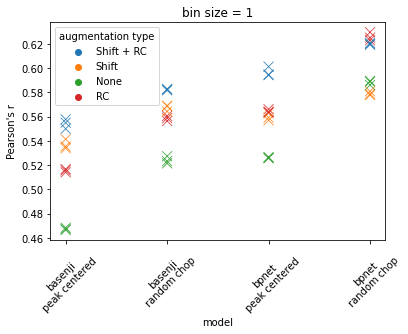

In [111]:
sns.scatterplot(data=avg_perf_complete.sort_values('model'), x='model', y='pr_corr', 
               hue='augmentation type', s=100, alpha=0.9, marker='x')
plt.xticks(rotation=45);
plt.title(title_str);
plt.ylabel('Pearson\'s r')

In [82]:
all_robustness_scores = []
for one_run_dir in avg_perf_complete['run_dir'].values:
    res_path = glob.glob('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/robustness_test/*/*_{}/variance_of_preds.h5'.format(os.path.basename(one_run_dir)))
    assert len(res_path) == 1, 'Too many results!'
    robustness_result_path = res_path[0]
    h5_dataset = h5py.File(robustness_result_path, 'r')
    all_robustness_scores.append((h5_dataset['prediction_variance'][:]).mean())
    h5_dataset.close()
    
avg_perf_complete['robustness score'] = all_robustness_scores



In [83]:
avg_perf_complete = avg_perf_complete.sort_values('model')

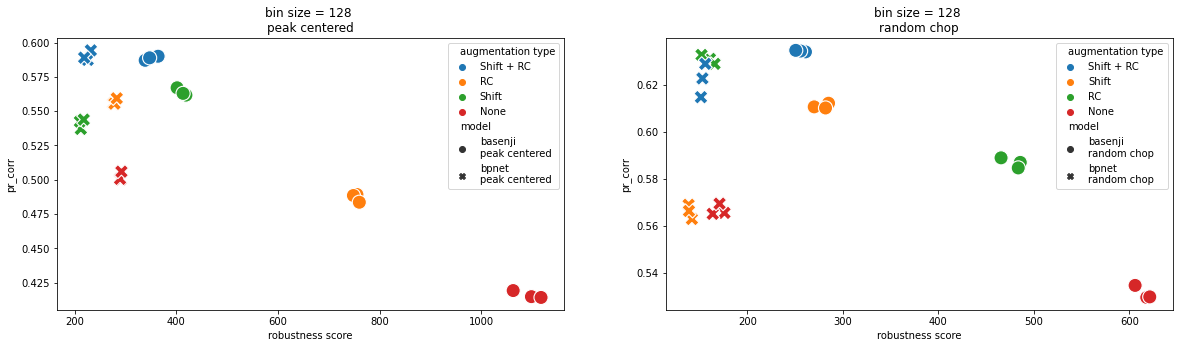

In [93]:
fig, axs = plt.subplots(1,2,figsize=[20,5])
for i, dataset_type in enumerate(['peak centered', 'random chop']):
    sns.scatterplot(data=avg_perf_complete[avg_perf_complete['dataset']==dataset_type], 
                    x='robustness score', y='pr_corr', 
                    hue='augmentation type', ax=axs[i], style='model', s=200)
    axs[i].set_title('{} \n{}'.format(title_str, dataset_type))
# sns.scatterplot(data=avg_perf_complete, 
#                 x='robustness score', y='pr_corr', 
#                 hue='augmentation type', style='model', s=100)

# Peak centered performance VS peak centered robustness

In [6]:
augm_dict = {('False', False): 'None', 
                 ('r_crop', False): 'Shift', 
                 ('False', True): 'RC', 
                 ('r_crop', True): 'Shift + RC'}


model_name = 'bpnet'
performance_whole = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/augmentation_48.csv')
bin_size=1
# title_str = '{} bin size {}, dataset={}'.format(model_name, bin_size, dataset_type)
whole_raw_performance = performance_whole[(performance_whole['pred type']=='raw')
                                          &(performance_whole['eval type']=='whole')
                                         &(performance_whole['bin_size']==bin_size)]
descriptions = whole_raw_performance.iloc[:,7:]
avg_perf = whole_raw_performance.groupby('run_dir').mean().reset_index()
avg_perf_complete = avg_perf.merge(descriptions, how='left', left_on='run_dir',right_on='run_dir').drop_duplicates(subset='run_dir')


avg_perf_complete['dataset'] = ['peak centered' if 'peak' in d else 'random chop' for d in avg_perf_complete['data_dir']]
avg_perf_complete['augmentation type'] = [augm_dict[(c,r)] for (c,r) in zip(avg_perf_complete['crop'], avg_perf_complete['rev_comp_x'])]
avg_perf_complete = avg_perf_complete.sort_values('augmentation type')



In [8]:
all_robustness_scores = []
all_perf_peak_center = []
for one_run_dir in tqdm(avg_perf_complete['run_dir'].values):
    robustness_result_path = glob.glob('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/robustness_test/{}/*_{}/variance_of_preds.h5'.format(model_name, os.path.basename(one_run_dir)))[0]
    h5_dataset = h5py.File(robustness_result_path, 'r')
    center_ground_truth_1K = h5_dataset['center_ground_truth_1K'][:]
    center_pred = h5_dataset['center_pred'][:]
    all_robustness_scores.append((h5_dataset['prediction_variance'][:]).mean())
    all_perf_peak_center.append((np.array(metrics.get_correlation_per_seq(center_pred, 
                                center_ground_truth_1K, take_avg=True))).mean())
    h5_dataset.close()
    
avg_perf_complete['robustness score'] = all_robustness_scores
avg_perf_complete['pearson r (IDR)'] = all_perf_peak_center

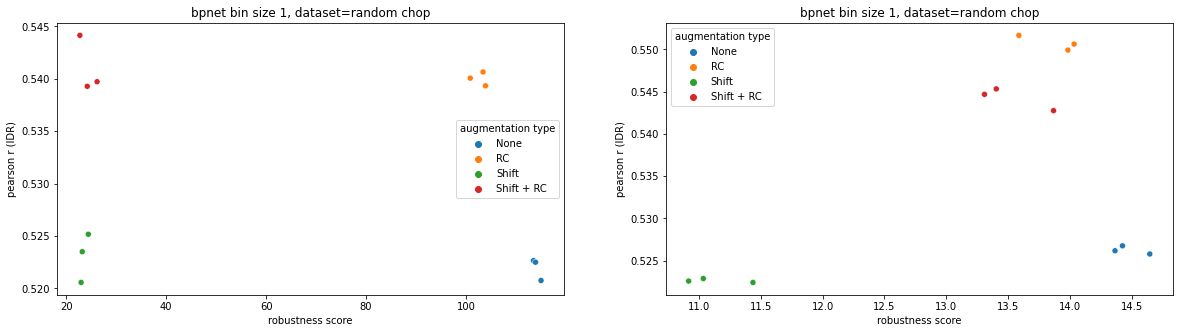

In [231]:
fig, axs = plt.subplots(1,2,figsize=[20,5])
for i, dataset_type in enumerate(['peak centered', 'random chop']):
    sns.scatterplot(data=avg_perf_complete[avg_perf_complete['dataset']==dataset_type], 
                    x='robustness score', y='pearson r (IDR)', 
                    hue='augmentation type', ax=axs[i])
    axs[i].set_title(title_str)



# prediction performance VS robustness per seq for peak centered dataset 

In [2]:
augm_dict = {('False', False): 'None', 
                 ('r_crop', False): 'Shift', 
                 ('False', True): 'RC', 
                 ('r_crop', True): 'Shift + RC'}


model_name = 'basenji'
performance_whole = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/augmentation_basenji.csv')
bin_size=1
# title_str = '{} bin size {}, dataset={}'.format(model_name, bin_size, dataset_type)
whole_raw_performance = performance_whole[(performance_whole['pred type']=='raw')
                                          &(performance_whole['eval type']=='whole')
                                         &(performance_whole['bin_size']==1)]
descriptions = whole_raw_performance.iloc[:,7:]
avg_perf = whole_raw_performance.groupby('run_dir').mean().reset_index()
avg_perf_complete = avg_perf.merge(descriptions, how='left', left_on='run_dir',right_on='run_dir').drop_duplicates(subset='run_dir')


avg_perf_complete['dataset'] = ['peak centered' if 'peak' in d else 'random chop' for d in avg_perf_complete['data_dir']]
avg_perf_complete['augmentation type'] = [augm_dict[(c,r)] for (c,r) in zip(avg_perf_complete['crop'], avg_perf_complete['rev_comp_x'])]
avg_perf_complete = avg_perf_complete.sort_values('augmentation type')

In [3]:
avg_perf_complete.head()


,run_dir,index,mse,js_per_seq,js_conc,poiss,pr_corr,sp_corr,bin_size_x,l_rate_x,...,crop,data_dir,l_rate_y,loss_fn,model_fn,num_epochs_y,rev_comp_y,window_size_y,dataset,augmentation type
345,paper_runs/basenji/augmentation_basenji/run-20...,7,0.744375,0.334080,0.373242,0.814370,0.527314,0.466187,1,0.001,...,False,datasets/complete/random_chop/i_2048_w_1,0.001,poisson,basenji_w1_b64,100,False,2048,random chop,None
315,paper_runs/basenji/augmentation_basenji/run-20...,7,0.952122,0.343404,0.389631,0.845657,0.468358,0.407325,1,0.001,...,False,datasets/complete/peak_centered/i_2048_w_1,0.001,poisson,basenji_w1_b64,100,False,2048,peak centered,None
75,paper_runs/basenji/augmentation_basenji/run-20...,7,0.752506,0.334508,0.373464,0.815016,0.523223,0.465990,1,0.001,...,False,datasets/complete/random_chop/i_2048_w_1,0.001,poisson,basenji_w1_b64,100,False,2048,random chop,None
105,paper_runs/basenji/augmentation_basenji/run-20...,7,0.962179,0.343658,0.389825,0.846178,0.467178,0.406826,1,0.001,...,False,datasets/complete/peak_centered/i_2048_w_1,0.001,poisson,basenji_w1_b64,100,False,2048,peak centered,None
225,paper_runs/basenji/augmentation_basenji/run-20...,7,0.752901,0.334231,0.373556,0.815090,0.521424,0.466106,1,0.001,...,False,datasets/complete/random_chop/i_2048_w_1,0.001,poisson,basenji_w1_b64,100,False,2048,random chop,None


In [6]:
cell_line = 3
all_model_one_cell_result = {}
for i, (label, df) in enumerate(avg_perf_complete.sort_values('dataset').groupby(['augmentation type', 'dataset', 'bin_size_x'])):
    print(label)
    one_run_dir = df['run_dir'].values[0]
    robustness_result_path = glob.glob('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/robustness_test/{}/*_{}/variance_of_preds.h5'.format(model_name, os.path.basename(one_run_dir)))[0]
    h5_dataset = h5py.File(robustness_result_path, 'r')
    center_ground_truth_1K = h5_dataset['center_ground_truth_1K'][:]
    center_pred = h5_dataset['center_pred'][:]
    robust_pred = h5_dataset['robust_pred'][:]
    prediction_variance = h5_dataset['prediction_variance'][:]
#     all_perf_peak_center.append((np.array(metrics.get_correlation_per_seq(center_pred, 
#                                 center_ground_truth_1K, take_avg=True))).mean())
    h5_dataset.close()
    center_pearsonr = np.squeeze(metrics.get_correlation_per_seq(np.expand_dims(center_pred[:,:,cell_line], axis=-1),
                                                     np.expand_dims(center_ground_truth_1K[:,:,cell_line], axis=-1),
                                                     take_avg=False))
    robust_pearsonr = np.squeeze(metrics.get_correlation_per_seq(np.expand_dims(robust_pred[:,:,cell_line], axis=-1),
                                                 np.expand_dims(center_ground_truth_1K[:,:,cell_line], axis=-1),
                                                 take_avg=False))
    summary_per_cell_line = pd.DataFrame({'center pearson r': center_pearsonr, 
                                          'robust pearson r': robust_pearsonr,
                                      'sqrt(robustness) / mean(coverage)': np.sqrt(prediction_variance[:,cell_line])/robust_pred[:,:,cell_line].mean(axis=-1),
                                      'mean cov': center_ground_truth_1K[:,:,cell_line].mean(axis=-1)})
    all_model_one_cell_result[label] = summary_per_cell_line
    

('None', 'peak centered', 1)
('None', 'random chop', 1)
('RC', 'peak centered', 1)
('RC', 'random chop', 1)
('Shift', 'peak centered', 1)
('Shift', 'random chop', 1)
('Shift + RC', 'peak centered', 1)
('Shift + RC', 'random chop', 1)


In [22]:
all_models_comp = {}
all_models_comp['labels'] = []
all_models_comp['center pr'] = [] 
all_models_comp['robust pr'] = []
for i, (label, df) in enumerate(avg_perf_complete.sort_values('dataset').groupby(['augmentation type', 'dataset', 'bin_size_x'])):
    for one_run_dir in df['run_dir'].values:
        robustness_result_path = glob.glob('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/robustness_test/{}/*_{}/variance_of_preds.h5'.format(model_name, os.path.basename(one_run_dir)))[0]
        h5_dataset = h5py.File(robustness_result_path, 'r')
        center_ground_truth_1K = h5_dataset['center_ground_truth_1K'][:]
        center_pred = h5_dataset['center_pred'][:]
        robust_pred = h5_dataset['robust_pred'][:]

        h5_dataset.close()
        center_pearsonr = np.squeeze(metrics.get_correlation_per_seq(center_pred,
                                                     center_ground_truth_1K,
                                                     take_avg=False))
        robust_pearsonr = np.squeeze(metrics.get_correlation_per_seq(robust_pred,
                                                 center_ground_truth_1K,
                                                 take_avg=False))

        all_models_comp['labels'].append(label)
        all_models_comp['center pr'].append(np.nanmean(center_pearsonr))
        all_models_comp['robust pr'].append(np.nanmean(robust_pearsonr))

/home/shush/tf_2/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


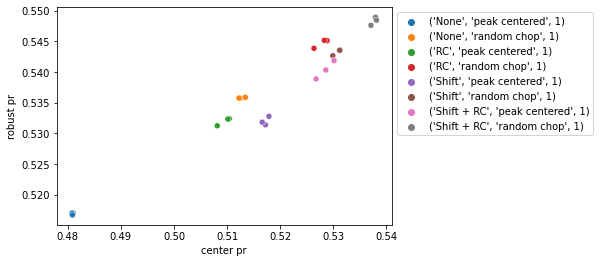

In [24]:
sns.scatterplot(data=pd.DataFrame(all_models_comp), x='center pr',
               y='robust pr', hue='labels')
plt.legend(bbox_to_anchor=[1,1])


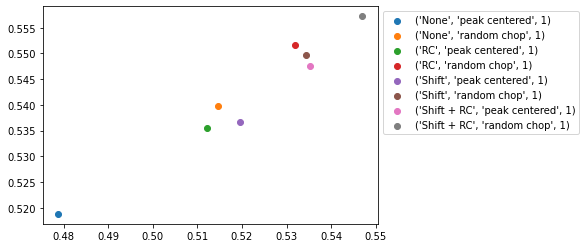

In [20]:
for descr, df in all_model_one_cell_result.items():
    c = np.nanmean(df['center pearson r'].values)
    r = np.nanmean(df['robust pearson r'].values)
    plt.scatter(c, r, label = descr)
plt.legend(bbox_to_anchor=[1,1])

<AxesSubplot:xlabel='center pearson r', ylabel='robust pearson r'>

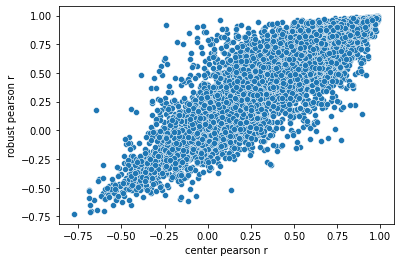

In [9]:
sns.scatterplot(data=all_model_one_cell_result[('None', 'peak centered', 1)],
                x='center pearson r', y='robust pearson r')

In [50]:
for k,df in avg_perf_complete.sort_values('dataset').groupby(['augmentation type', 'dataset', 'bin_size_x']):
    print(k)
    print(df['run_dir'].values[0])

('None', 'peak centered', 1)
paper_runs/basenji/augmentation_basenji/run-20210925_100300-d2gogddo
('None', 'random chop', 1)
paper_runs/basenji/augmentation_basenji/run-20210925_100301-fq6vq6zb
('RC', 'peak centered', 1)
paper_runs/basenji/augmentation_basenji/run-20210924_045530-c7k7jwqa
('RC', 'random chop', 1)
paper_runs/basenji/augmentation_basenji/run-20210924_045531-hwhdrer9
('Shift', 'peak centered', 1)
paper_runs/basenji/augmentation_basenji/run-20210925_100137-zim02k9a
('Shift', 'random chop', 1)
paper_runs/basenji/augmentation_basenji/run-20210924_103004-unm4qloe
('Shift + RC', 'peak centered', 1)
paper_runs/basenji/augmentation_basenji/run-20210924_103004-xkwwp3jl
('Shift + RC', 'random chop', 1)
paper_runs/basenji/augmentation_basenji/run-20210925_100205-2ix9rvge


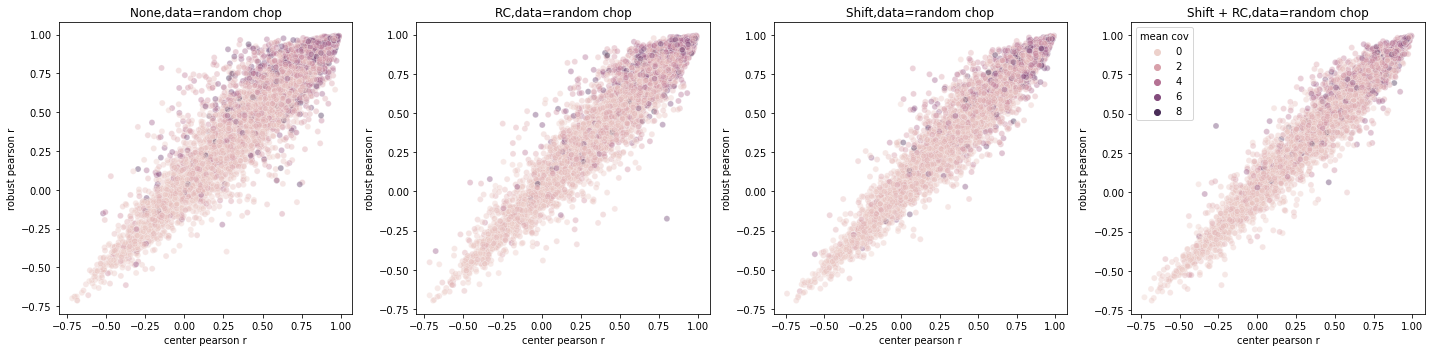

In [11]:
cell_line = 3
nrows, ncols = 1, 4
fig = plt.figure(figsize=[20,5])
i=1
for label, summary_per_cell_line in all_model_one_cell_result.items():
    if 'random chop' in label:
        ax = fig.add_subplot(nrows, ncols, i)

        sns.scatterplot(data = summary_per_cell_line, x= 'center pearson r', 
#                     y = 'sqrt(robustness) / mean(coverage)', 
                        y = 'robust pearson r',
                    alpha=0.4, hue='mean cov')
        ax.set_title('{},data={}'.format(label[0], label[1]))

        if i!=4:
            ax.get_legend().remove()
        i+=1
plt.tight_layout()

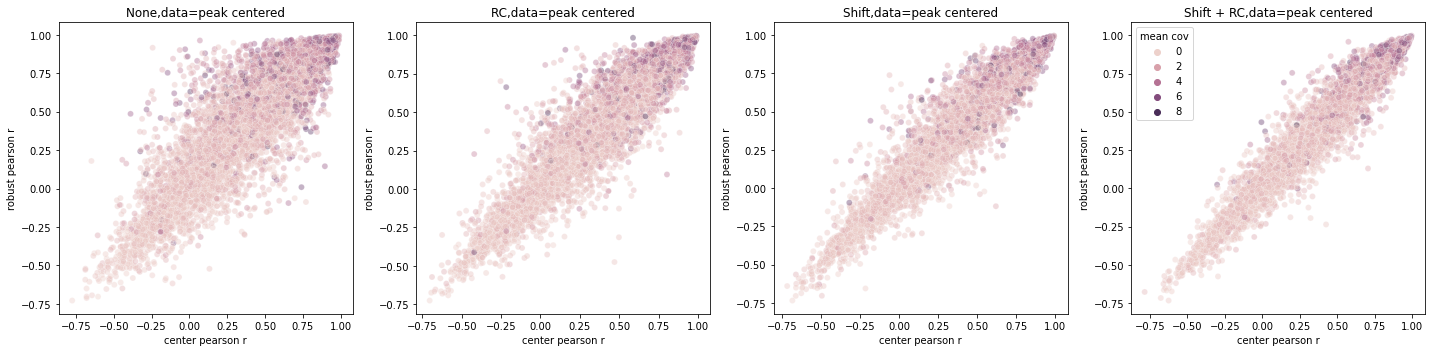

In [13]:
cell_line = 3
nrows, ncols = 1, 4
fig = plt.figure(figsize=[20,5])
i=1
for label, summary_per_cell_line in all_model_one_cell_result.items():
    if 'peak centered' in label:
        ax = fig.add_subplot(nrows, ncols, i)

        sns.scatterplot(data = summary_per_cell_line, x= 'center pearson r', 
#                     y = 'sqrt(robustness) / mean(coverage)', 
                        y = 'robust pearson r',
                    alpha=0.4, hue='mean cov')
        ax.set_title('{},data={}'.format(label[0], label[1]))

        if i!=4:
            ax.get_legend().remove()
        i+=1
plt.tight_layout()

cell line = HCT116



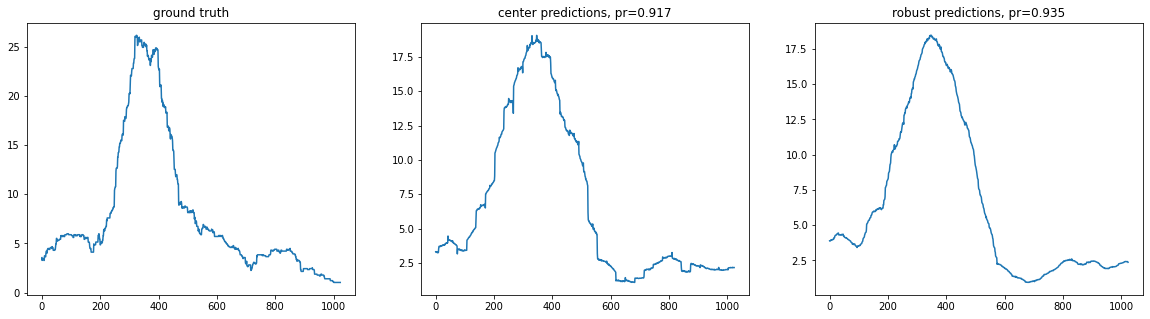

In [160]:
i = 396
y = np.concatenate(center_ground_truth_1K)[i,:,:]
max_cell = np.argmax(np.sum(y, axis=0), axis=-1)

fig, axs = plt.subplots(1,3, figsize=[20,5])

axs[0].plot(y[:,max_cell]);
axs[0].set_title('ground truth')

axs[1].plot(np.concatenate(predictions_and_variance['center_pred'])[i,:,max_cell]);
axs[1].set_title('center predictions, pr={}'.format(np.round(center_pearsonr[max_cell,i], 3)))

axs[2].plot(np.concatenate(predictions_and_variance['robust_pred'])[i,:,max_cell]);
axs[2].set_title('robust predictions, pr={}'.format(np.round(robust_pearsonr[max_cell,i], 3)));

print('cell line = ' + targets[max_cell])
print('')

In [119]:
np.concatenate(center_1K_coordinates)[i]

array(['chr8', '53286895', '53287918'], dtype='<U8')

1. compare everything (center pred and shift pred) to base res ground truth 
2. get binned preds, shift (mean), bin again vs binned ground truth VS (center pred vs binned)
3. get binned preds, shift (mean) vs binned ground truth VS (center pred vs binned)

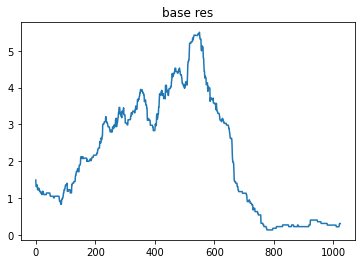

In [98]:
i = 8
max_cell = np.argmax(np.sum((Y[i,:,:]),axis=0), axis=-1)
plt.plot(Y[i,conserve_start:conserve_end+1,max_cell]);
plt.title('base res');


Text(0.5, 1.0, '')

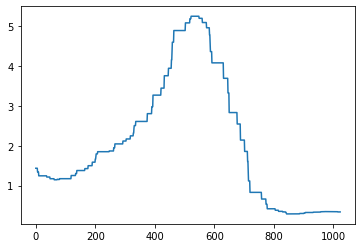

In [99]:
plt.plot(batch_avg_predictions[i,:,max_cell])
plt.title('')

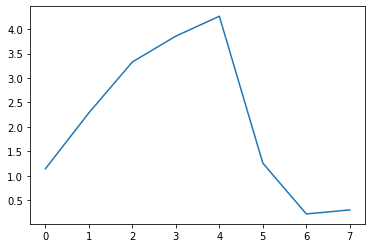

In [100]:
binned_center_Y = (Y[i,conserve_start:conserve_end+1,max_cell]).numpy().reshape(1024//128, 128).mean(axis=1)
plt.plot(binned_center_Y)

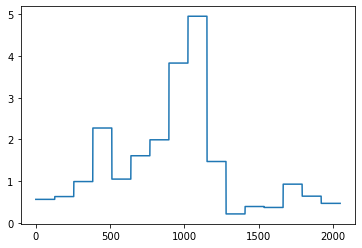

In [101]:
plt.plot(center_2K_pred_unbinned[i,:,max_cell])

In [132]:
pearsonr(center_2K_pred_unbinned[i,(2048//2-512):(2048//2+512),max_cell], Y[i,conserve_start:conserve_end+1,max_cell])

(0.8810236613183462, 0.0)

In [133]:
center_2K_pred_unbinned.shape

(64, 2048, 15)

In [122]:
center_2K_pred_unbinned[i,(2048//2-512):(2048//2+512),max_cell].shape

(1024,)

In [130]:
Y[i,conserve_start:conserve_end+1,max_cell].shape

TensorShape([0])

In [109]:
2048//2+512+1

1537